# Comparison of astrophysical fluxes with the event

This notebook shows how to produce the flux plot shown in the publication:
- It is exploiting the KM3NeT effective area (available as csv file in the same repository) to compute the flux corresponding to one expected event in KM3NeT.
- The constraints from other experiments have been collected to be plotted as comparisons.
- Bands are shown for two origin hypotheses: cosmogenic and transient sources.

In [1]:
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

sys.path.append("../src")

from fluxmethods import E2Phi, get_singlepowerlaw_iceCube, get_segmented_icecube

# Inputs

In [2]:
# Feldman-Cousins intervals computed with ROOT.TFeldmanCousins (hardcoded here to avoid ROOT import)
feldmancousins_intervals = {
    "1sigma": np.array([0.3679, 2.7506]),
    "2sigma": np.array([0.0466, 5.1433]),
    "3sigma": np.array([0.0028, 8.3077]),
}

### KM3NeT inputs

The sky-averaged all-flavour $\nu+\bar\nu$ effective area $A_{\rm eff}(E)$ is used to compute the flux needed to get one expected event in KM3NeT, assuming an $E^{-2}$ spectrum.
$$\Phi(E) = \Phi_{\nu+\bar\nu}^{1\,GeV} \times (E/GeV)^{-2}$$
$$N_{\rm exp} = 4\pi \times T_{\rm livetime} \times \Phi_{\nu+\bar\nu}^{1\,GeV} \times 1/2 \times \int A_{\rm eff}(E) \times (E/GeV)^{-2} {\rm d}E$$
$$N_{\rm exp} = 1 \Leftrightarrow \Phi_{\nu+\bar\nu}^{1\,GeV} = \dfrac{2}{4\pi \times T_{\rm livetime} \times \int A_{\rm eff}(E) \times (E/GeV)^{-2} {\rm d}E}$$
with $\Phi^{1\,GeV}$ in /GeV/cm²/s/sr, $A_{\rm eff}(E)$ in cm², $T_{\rm livetime}$ in s.

In [3]:
livetime_arca = 335 * 86400  # in seconds

df_aeff_arca = pd.read_json("../data/supplementary/simulations/effective_area_brighttrackselection_allflavour_skyavg.json")

x_aeff_arca, y_aeff_arca = df_aeff_arca["Energy [GeV]"], df_aeff_arca["Aeff [cm^2]"]
f_aeff_arca = interp1d(x_aeff_arca, y_aeff_arca, bounds_error=False, fill_value=0)

### Flux in 90\% neutrino energy range of KM3-230213A event

In [4]:
energy5_evt, energy50_evt, energy95_evt = 7.24e7, 2.18e8, 2.57e9

x = np.logspace(np.log10(energy5_evt), np.log10(energy95_evt), 200)
acceptance_arca = trapezoid(y=x**-2 * f_aeff_arca(x), x=x)
flux_arca = 1 / (4 * np.pi * livetime_arca * acceptance_arca)
interval1sigma_flux_arca = feldmancousins_intervals["1sigma"] * flux_arca
interval2sigma_flux_arca = feldmancousins_intervals["2sigma"] * flux_arca
interval3sigma_flux_arca = feldmancousins_intervals["3sigma"] * flux_arca

print(f"Phi(1 GeV, evt range) = {flux_arca:.2e}")
print(f"  > 1 sigma interval = {interval1sigma_flux_arca[0]:.2e} -- {interval1sigma_flux_arca[1]:.2e}")
print(f"  > 2 sigma interval = {interval2sigma_flux_arca[0]:.2e} -- {interval2sigma_flux_arca[1]:.2e}")
print(f"  > 3 sigma interval = {interval3sigma_flux_arca[0]:.2e} -- {interval3sigma_flux_arca[1]:.2e}")

Phi(1 GeV, evt range) = 5.80e-08
  > 1 sigma interval = 2.13e-08 -- 1.59e-07
  > 2 sigma interval = 2.70e-09 -- 2.98e-07
  > 3 sigma interval = 1.62e-10 -- 4.82e-07


### Existing constraints

Limits:
- IceCube-EHE → [Phys. Rev. D 98, 062003](https://link.aps.org/doi/10.1103/PhysRevD.98.062003)
- Auger → [PoS ICRC2023 1488](https://pos.sissa.it/444/1488/pdf)
- ANTARES → [JCAP08 (2024) 038](https://doi.org/10.1088/1475-7516/2024/08)

IceCube single power law fits and segmented fits:
- Northern-Sky Tracks (NST) → [Ap.J. 928 50](https://iopscience.iop.org/article/10.3847/1538-4357/ac4d29)
- HESE best fit SPL [2021] → [Phys. Rev. D 104, 022002](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.104.022002)

In [5]:
icecube_ehe_limits = pd.read_json("../data/external/flux_constraints/limits_differential_icecube-ehe.json").to_numpy().T
auger_limits = pd.read_json("../data/external/flux_constraints/limits_differential_auger.json").to_numpy().T
antares_limits = pd.read_json("../data/external/flux_constraints/limits_differential_antares.json").to_numpy().T

In [6]:
icecube_singlepowerlaw_bestfit = pd.read_json("../data/external/flux_constraints/icecube_spl_bestfit.json")

icecube_singlepowerlaw_contour68 = {
    "HESE": pd.read_json("../data/external/flux_constraints/icecube_spl_hese_contour1sigma.json"),
    "NST": pd.read_json("../data/external/flux_constraints/icecube_spl_nst_contour1sigma.json")
}

icecube_segmentedfit = {
    "HESE": pd.read_json("../data/external/flux_constraints/icecube_segmentedfit_hese.json"),
    "NST": pd.read_json("../data/external/flux_constraints/icecube_segmentedfit_nst.json"),
    "Glashow": pd.read_json("../data/external/flux_constraints/icecube_segmentedfit_glashow.json")
}

### Models

In [7]:
x_cosmogenic_band, ymin_cosmogenic_band, ymax_cosmogenic_band = pd.read_json("../data/external/flux_models/cosmogenic_band.json").replace(np.nan, -np.inf).to_numpy().T
ymin_cosmogenic_band = 10**ymin_cosmogenic_band
ymax_cosmogenic_band = 10**ymax_cosmogenic_band
x_source_band, ymin_source_band, ymax_source_band = pd.read_json("../data/external/flux_models/source_band.json").replace(np.nan, -np.inf).to_numpy().T
ymin_source_band = 10**ymin_source_band
ymax_source_band = 10**ymax_source_band

### Plot

/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


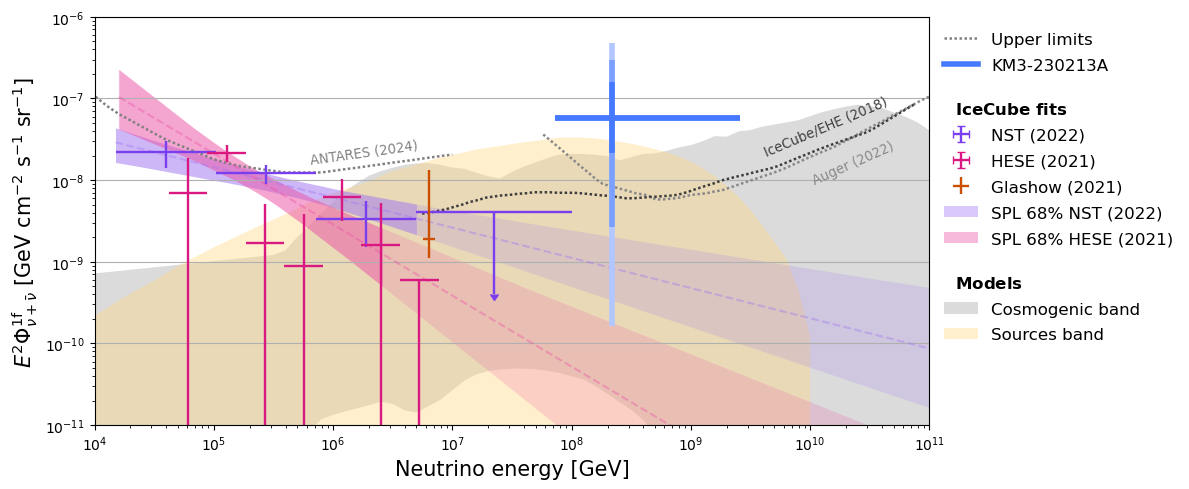

In [8]:
fig = plt.figure(figsize=(12, 5))

# Model bands
p_cosmoband = plt.fill_between(x_cosmogenic_band, ymin_cosmogenic_band, ymax_cosmogenic_band, color="#a6a6a6", alpha=0.4, lw=0, label=r"Cosmogenic band")
p_sourceband = plt.fill_between(x_source_band, ymin_source_band, ymax_source_band, color="#ffd880", alpha=0.4, lw=0, label=r"Sources band")

# ANTARES/Auger/IceCube-EHE upper limits
plt.plot(*antares_limits, color="#808080", ls=(0, (1, 1)), lw=1.8)
plt.plot(*auger_limits, color="#888888", ls=(0, (1, 1)), lw=1.8)
plt.plot(*icecube_ehe_limits, color="#3E3E3E", ls=(0, (1, 1)), lw=1.8)
# Corresponding labels
plt.text(10**5.8, 10**(-7.8), "ANTARES (2024)", c="#808080", fontsize=9.5, rotation=8)
plt.text(10**10, 0.5 * 10**-7.75, "Auger (2022)", c="#888888", fontsize=9.5, rotation=24)
plt.text(10**9.6, 10**(-7.7), "IceCube/EHE (2018)", c="#3E3E3E", fontsize=9.5, rotation=23)

# IceCube single powerlaw fits
x, y, y_min, y_max, yext_min, yext_max = get_singlepowerlaw_iceCube(icecube_singlepowerlaw_bestfit["NST"], icecube_singlepowerlaw_contour68["NST"])
p_spl_nst = plt.fill_between(x, y_min, y_max, color="#a076f2", alpha=0.4, lw=0, label=r"SPL 68% NST (2022)")
plt.fill_between(x, yext_min, yext_max, color="#a076f2", alpha=0.2, lw=0)
plt.plot(x, y, color="#a076f2", alpha=0.4, ls="dashed")
x, y, y_min, y_max, yext_min, yext_max = get_singlepowerlaw_iceCube(icecube_singlepowerlaw_bestfit["HESE"], icecube_singlepowerlaw_contour68["HESE"])
p_spl_hese = plt.fill_between(x, y_min, y_max, color="#ec53a7", alpha=0.4, lw=0, label=r"SPL 68% HESE (2021)")
plt.fill_between(x, yext_min, yext_max, color="#ec53a7", alpha=0.2, lw=0)
plt.plot(x, y, color="#ec53a7", alpha=0.4, ls="dashed")

# IceCube segmented fits
x, y, xerr, yerr = get_segmented_icecube(icecube_segmentedfit["NST"])
p_seg_nst = plt.errorbar(x, y, xerr=xerr, yerr=yerr, color="#793eed", ls='none', lw=1.7, uplims=(yerr[1] == 0), label=r"NST (2022)")
x, y, xerr, yerr = get_segmented_icecube(icecube_segmentedfit["HESE"])
p_seg_hese = plt.errorbar(x, y, xerr=xerr, yerr=yerr, color="#da1882", ls='none', lw=1.7, uplims=(yerr[1] == 0), label=r"HESE (2021)")
x, y, xerr, yerr = get_segmented_icecube(icecube_segmentedfit["Glashow"])
p_seg_glas = plt.errorbar(x, y, xerr=xerr, yerr=yerr, color="#cc4e00", ls='none', lw=1.7, uplims=(yerr[1] == 0), label=r"Glashow (2021)")

# KM3NeT flux crosses
plt.errorbar(
    x=[energy50_evt], y=[flux_arca],
    xerr=[[energy50_evt-energy5_evt], [energy95_evt-energy50_evt]],
    yerr=[[flux_arca-interval3sigma_flux_arca[0]], [interval3sigma_flux_arca[1]-flux_arca]],
    color="#b2c7ff", lw=4
)
plt.errorbar(
    x=[energy50_evt], y=[flux_arca],
    xerr=[[energy50_evt-energy5_evt], [energy95_evt-energy50_evt]],
    yerr=[[flux_arca-interval2sigma_flux_arca[0]], [interval2sigma_flux_arca[1]-flux_arca]],
    color="#7ba0ff", lw=4
)
plt.errorbar(
    x=[energy50_evt], y=[flux_arca],
    xerr=[[energy50_evt-energy5_evt], [energy95_evt-energy50_evt]],
    yerr=[[flux_arca-interval1sigma_flux_arca[0]], [interval1sigma_flux_arca[1]-flux_arca]],
    color="#4579ff", lw=4
)

# Axis
plt.xlabel(r"Neutrino energy [GeV]", fontsize=15)
plt.ylabel(r"$E^2 \Phi_{\nu+\bar\nu}^{\text{1f}}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]", fontsize=15)
plt.xscale("log")
plt.yscale("log")
plt.xlim((1e4, 1e11))
plt.ylim((1e-11, 1e-6))
plt.grid(axis="y")

# Legend
handles = []
handles.append(matplotlib.lines.Line2D([], [], color="#808080", ls=(0, (1, 1)), lw=1.8, label=r"Upper limits"))
handles.append(matplotlib.lines.Line2D([], [], color="#4579ff", lw=4, label=r"KM3-230213A"))
handles.append(matplotlib.lines.Line2D([], [], color="none", label="\n$\\bf{IceCube\\ fits}$"))
handles.append(p_seg_nst)
handles.append(p_seg_hese)
handles.append(p_seg_glas)
handles.append(p_spl_nst)
handles.append(p_spl_hese)
handles.append(matplotlib.lines.Line2D([], [], color="none", label="\n$\\bf{Models}$"))
handles.append(p_cosmoband)
handles.append(p_sourceband)
leg = plt.legend(handles=handles, fontsize=12, bbox_to_anchor=(1, 1), loc="upper left", labelspacing=0.65, fancybox=True, framealpha=1, frameon=False)
for item, label in zip(leg.legend_handles, leg.texts):
    if label._text.startswith("\n"):
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.5 * width, 0))

plt.tight_layout()

plt.show()